#A) BUSINESS QUESTION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




1. How was the trend of the number of bottles sold between January 2021 to January 2022?
  * date
  * bottle sold
  * category name

2. How much revenue does Iowa make from the business each month? Which product drives the most sales?
  * date
  * sale dollar
  * item description

3. Are there any variations among regions in terms of the most popular product?
  * item description
  * county
  * bottle sold

4. How many bottles will Iowa sell in the next three months?
  * category name
  * bottle sold
  * date

#B) PROBLEM STATEMENT

1. How was the trend of the number of bottles sold between January 2021 to January 2022?
2. How much revenue does Iowa make from the business each month? Which product drives the most sales?
3. Are there any variations among regions in terms of the most popular product?
4. How many bottles will Iowa sell in the next three months?

#C) DATA DICTIONARIES

1)** invoice_and_item_number**: concatenated invoice and line number associated with the liquor order. This provides a unique identifier for the individual liquor products included in the store order.

2) **date**: date of order.

3) **store_number**: unique number assigned to the store who ordered the liquor.

4) **store_name**: name of store who ordered the liquor.

5) **address**: address of store who ordered the liquor.

6) **city**: city where the store who ordered the liquor is located.

7) **zip_code**: zip code where the store who ordered the liquor is located.

8) **store_location**: location of store who ordered the liquor. The address, city,
state and zip code are geocoded to provide geographic coordinates.

9) **county_number**: iowa county number for the county where store who ordered the liquor is located.

10) **county**: county where the store who ordered the liquor is located.

11) **category**: category code associated with the liquor ordered.

12) **category_name**: category of the liquor ordered.

13) **vendor_number**: the vendor number of the company for the brand of liquor ordered.

14) **vendor_name**: the vendor name of the company for the brand of liquor ordered.

15) **item_number**: item number for the individual liquor product ordered.

16) **item_description**: description of the individual liquor product ordered.

17) **pack**: the number of bottles in a case for the liquor ordered.

18) **bottle_volume_ml**: volume of each liquor bottle ordered in milliliters.

19) **state_bottle_cost**: the amount that alcoholic beverages division paid for each bottle of liquor ordered.

20) **state_bottle_retail**: the amount the store paid for each bottle of liquor ordered.

21) **bottles_sold**: the number of bottles of liquor ordered by the store.

22) **sale_dollars**: total cost of liquor order (number of bottles multiplied by the state bottle retail).

23) **volume_sold_liters**: total volume of liquor ordered in liters. (i.e. (bottle volume (ml) x bottles sold)/1,000).

24) **volume_sold_gallons**: total volume of liquor ordered in gallons. (i.e. (bottle volume (ml) x bottles sold)/3785.411784).

#D) RAW DATA PREPARATION

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          37245       1049  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           5835        153  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           7595        161  1.0              
mohithsairamreddy/salary-data 

In [ ]:
!kaggle datasets download -d 'gabrielramos87/iowa-sales-liquor-jan-2021jan-2022'

100% 129M/129M [00:06<00:00, 27.2MB/s]
100% 129M/129M [00:06<00:00, 21.3MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('iowa-sales-liquor-jan-2021jan-2022.zip','r')

dataset_zip.extractall()

dataset_zip.close()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans                                             # to perform the k-means algorithm
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler     # to sacalling different attribute
from sklearn import cluster                                                    # for machine learning and statistical modelling (we use it for clustering)

import matplotlib.cm as cm                                                     # provide a large set of colormaps(cm)
from sklearn.metrics import silhouette_samples, silhouette_score               # for perform silhoutte analysis
from sklearn.datasets import make_blobs
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Show dataset head named it as df_ori
pd.read_csv('/content/Iowa Liquor Sales (Jan 2021-Jan 2022).csv')
df_ori = pd.read_csv('/content/Iowa Liquor Sales (Jan 2021-Jan 2022).csv')
df_ori.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-33179700135,2021-01-04,2576,Hy-Vee Wine and Spirits / Storm Lake,1250 N Lake St,Storm Lake,50588.0,POINT (-95.200758 42.65318400000001),11.0,BUENA VIST,...,64870,Fireball Cinnamon Whiskey,48,100,0.90,1.35,48,64.80,4.8,1.26
1,INV-33196200106,2021-01-04,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001.0,POINT (-90.666497 42.49721900000001),31.0,DUBUQUE,...,65200,Tequila Rose Liqueur,12,750,11.50,17.25,4,69.00,3.0,0.79
2,INV-33184300011,2021-01-04,2539,Hy-Vee Food Store / Iowa Falls,640 S. Oak,Iowa Falls,50126.0,POINT (-93.262364 42.508752),42.0,HARDIN,...,38008,Smirnoff 80prf PET,6,1750,14.75,22.13,6,132.78,10.5,2.77
3,INV-33184100015,2021-01-04,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126.0,POINT (-93.262446 42.503407),42.0,HARDIN,...,36648,Caliber Vodka,12,750,3.31,4.97,12,59.64,9.0,2.37
4,INV-33174200025,2021-01-04,5385,Vine Food & Liquor,2704 Vine St.,West Des Moines,50265.0,POINT (-93.741511 41.580206),77.0,POLK,...,4626,Buchanan Deluxe 12YR,12,750,20.99,31.49,2,62.98,1.5,0.39


In [ ]:
df_ori.info()
df_ori.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805307 entries, 0 to 2805306
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   invoice_and_item_number  object 
 1   date                     object 
 2   store_number             int64  
 3   store_name               object 
 4   address                  object 
 5   city                     object 
 6   zip_code                 float64
 7   store_location           object 
 8   county_number            float64
 9   county                   object 
 10  category                 float64
 11  category_name            object 
 12  vendor_number            float64
 13  vendor_name              object 
 14  item_number              int64  
 15  item_description         object 
 16  pack                     int64  
 17  bottle_volume_ml         int64  
 18  state_bottle_cost        float64
 19  state_bottle_retail      float64
 20  bottles_sold             int64  
 21  sale_dol

(2805307, 24)

#E) DATA CLEANING

## Data Types and Shape

In [ ]:
df_dc = df_ori.copy()
df_dc.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-33179700135,2021-01-04,2576,Hy-Vee Wine and Spirits / Storm Lake,1250 N Lake St,Storm Lake,50588.0,POINT (-95.200758 42.65318400000001),11.0,BUENA VIST,...,64870,Fireball Cinnamon Whiskey,48,100,0.90,1.35,48,64.80,4.8,1.26
1,INV-33196200106,2021-01-04,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001.0,POINT (-90.666497 42.49721900000001),31.0,DUBUQUE,...,65200,Tequila Rose Liqueur,12,750,11.50,17.25,4,69.00,3.0,0.79
2,INV-33184300011,2021-01-04,2539,Hy-Vee Food Store / Iowa Falls,640 S. Oak,Iowa Falls,50126.0,POINT (-93.262364 42.508752),42.0,HARDIN,...,38008,Smirnoff 80prf PET,6,1750,14.75,22.13,6,132.78,10.5,2.77
3,INV-33184100015,2021-01-04,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126.0,POINT (-93.262446 42.503407),42.0,HARDIN,...,36648,Caliber Vodka,12,750,3.31,4.97,12,59.64,9.0,2.37
4,INV-33174200025,2021-01-04,5385,Vine Food & Liquor,2704 Vine St.,West Des Moines,50265.0,POINT (-93.741511 41.580206),77.0,POLK,...,4626,Buchanan Deluxe 12YR,12,750,20.99,31.49,2,62.98,1.5,0.39


In [ ]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805307 entries, 0 to 2805306
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   invoice_and_item_number  object 
 1   date                     object 
 2   store_number             int64  
 3   store_name               object 
 4   address                  object 
 5   city                     object 
 6   zip_code                 float64
 7   store_location           object 
 8   county_number            float64
 9   county                   object 
 10  category                 float64
 11  category_name            object 
 12  vendor_number            float64
 13  vendor_name              object 
 14  item_number              int64  
 15  item_description         object 
 16  pack                     int64  
 17  bottle_volume_ml         int64  
 18  state_bottle_cost        float64
 19  state_bottle_retail      float64
 20  bottles_sold             int64  
 21  sale_dol

In [ ]:
# count values in every columns
for kolom in df_dc.columns:
  print(df_dc[kolom].value_counts())

INV-33179700135    1
INV-38519900052    1
INV-38514900111    1
INV-38486800033    1
INV-38498500044    1
                  ..
INV-33951000025    1
INV-33952400159    1
INV-33952800009    1
INV-33953100080    1
INV-41968600005    1
Name: invoice_and_item_number, Length: 2805307, dtype: int64
2021-12-21    14363
2021-11-16    13831
2021-11-26    13738
2021-04-16    13484
2021-03-05    13456
              ...  
2021-11-14       10
2021-11-25        9
2021-05-02        6
2021-08-01        5
2021-03-07        5
Name: date, Length: 326, dtype: int64
2633    20534
4829    19568
2190    16962
2572    15484
3773    14552
        ...  
5889        5
9046        4
9049        3
5939        2
6260        1
Name: store_number, Length: 1954, dtype: int64
Hy-Vee #3 / BDI / Des Moines                20534
Central City 2                              19604
Central City Liquor, Inc.                   16926
Hy-Vee Food Store / Cedar Falls             15484
Benz Distributing                           14552

## Dropped NaN & Duplicate Values

In [ ]:
df_dc.isna().sum()

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                       142
city                          142
zip_code                      142
store_location             330335
county_number                 142
county                        142
category                        0
category_name                   0
vendor_number                   4
vendor_name                     4
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

In [ ]:
# Removing missing value

df_dc = df_dc.dropna()
df_dc.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
dtype: int64

In [ ]:
#330.339 rows has been dropped (2.805.307 rows to 2.474.968 rows)
df_dc.shape

(2474968, 24)

In [ ]:
df_dc[df_dc['invoice_and_item_number'].duplicated()]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons


In [ ]:
ordered_category_based_on_unique_cities = df_dc.groupby('category_name')['city'].nunique()
ordered_category_based_on_unique_cities


category_name
100% Agave Tequila                      385
Aged Dark Rum                           187
American Brandies                       344
American Cordials & Liqueur             396
American Cordials & Liqueurs             94
American Distilled Spirit Specialty     355
American Distilled Spirits Specialty     17
American Dry Gins                       372
American Flavored Vodka                 415
American Schnapps                       411
American Sloe Gins                      151
American Vodka                           64
American Vodkas                         430
American Whiskies                         1
Blended Whiskies                        427
Bottled in Bond Bourbon                 183
Canadian Whiskies                       428
Cocktails / RTD                          12
Cocktails /RTD                          388
Coffee Liqueurs                         307
Corn Whiskies                           127
Cream Liqueurs                          409
Distilled Spirits 

## Data Manipulation

Date

In [ ]:
df_dc['date'] = pd.to_datetime(df_dc['date'])

In [ ]:
df_dc.sample(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1876462,INV-38488000019,2021-07-20,4969,Lake Liquors Wine and Spirits,910 N 8th St W,Clear Lake,50428.0,POINT (-93.396651 43.142775),17.0,CERRO GORD,...,19477,Makers Mark,12,1000,22.04,33.06,4,132.24,4.0,1.05
2551815,INV-36917500058,2021-05-25,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806.0,POINT (-90.608201 41.560663),82.0,SCOTT,...,89198,Jose Cuervo Especial Reposado,6,1750,21.50,32.25,6,193.50,10.5,2.77
949013,INV-34048500047,2021-02-04,5126,Price Chopper / Merle Hay #1315,4343 Merle Hay Rd,Des Moines,50310.0,POINT (-93.697647 41.63740800000001),77.0,POLK,...,51326,Maraska Slivovitz,6,750,14.60,21.90,6,131.40,4.5,1.18
691501,INV-42714800004,2021-12-08,4630,EZ Stop / Davenport,2923 Brady St,Davenport,52803.0,POINT (-90.570603 41.549887),82.0,SCOTT,...,87280,Casamigos Blanco,6,750,26.84,40.26,6,241.56,4.5,1.18
1646238,INV-40131300022,2021-09-16,2622,Hy-Vee Food Store / Iowa City,1125 N Dodge St,Iowa City,52240.0,POINT (-91.518868 41.676095),52.0,JOHNSON,...,52595,E & J VS PET,12,750,6.50,9.75,12,117.00,9.0,2.37


In [ ]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474968 entries, 0 to 2805306
Data columns (total 24 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   invoice_and_item_number  object        
 1   date                     datetime64[ns]
 2   store_number             int64         
 3   store_name               object        
 4   address                  object        
 5   city                     object        
 6   zip_code                 float64       
 7   store_location           object        
 8   county_number            float64       
 9   county                   object        
 10  category                 float64       
 11  category_name            object        
 12  vendor_number            float64       
 13  vendor_name              object        
 14  item_number              int64         
 15  item_description         object        
 16  pack                     int64         
 17  bottle_volume_ml         in

## Checking duplicates

In [ ]:
df_dc[df_dc['invoice_and_item_number'].duplicated()] #No duplicate

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons


## Check & Remove Outliers

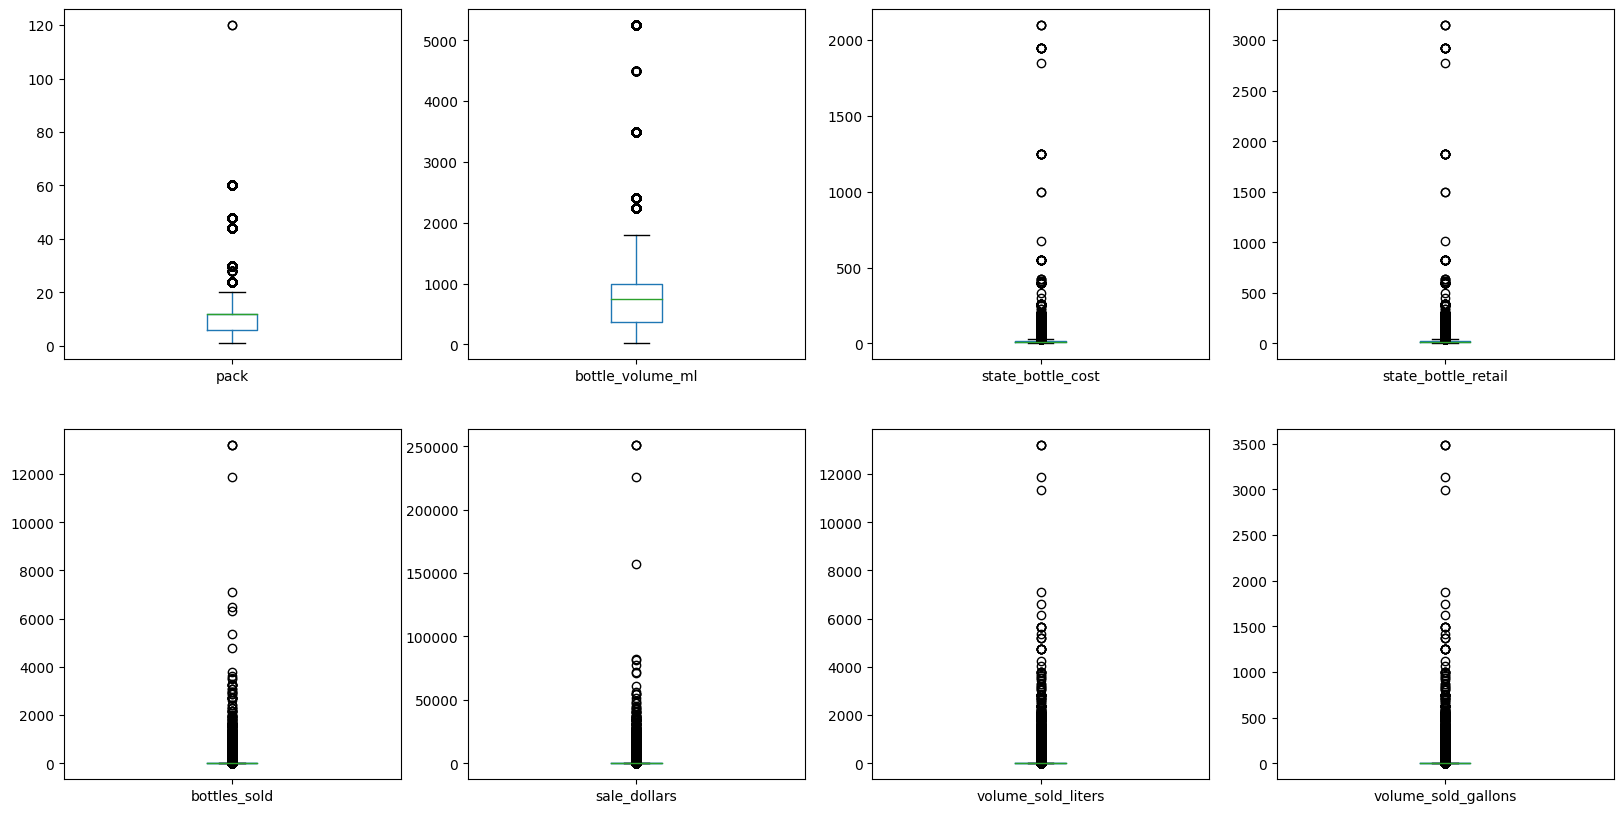

In [ ]:
# Boxplot before removing outliers
feature = ['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']

#adjust chart position and chart size
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))

# for 0 (i) , Income (el)
for i,el in enumerate(feature):
    a = df_dc.boxplot(el, ax=axes.flatten()[i],grid=False)

#Show Chart
plt.show()

Many outliers found, and it will be removed

In [ ]:
#Check the Q1,Q3,IQR,UB & LB
#pack = pack
print('Outlier Detection "pack"')
pack_Q1 = df_dc["pack"].quantile(0.25)
print("Q1 =",pack_Q1)

pack_Q3 = df_dc["pack"].quantile(0.75)
print("Q3 =",pack_Q3)

pack_IQR = pack_Q3 - pack_Q1
print("IQR =",pack_IQR)

pack_LB = pack_Q1-1.5*pack_IQR
print("LB =",pack_LB)

pack_UB = pack_Q3+1.5*pack_IQR
print("UB =",pack_UB)


#Check the Q1,Q3,IQR,UB & LB
#botvol = bottle_volume_ml
print('Outlier Detection "bottle_volume_ml"')
botvol_Q1 = df_dc["bottle_volume_ml"].quantile(0.25)
print("Q1 =",botvol_Q1)

botvol_Q3 = df_dc["bottle_volume_ml"].quantile(0.75)
print("Q3 =",botvol_Q3)

botvol_IQR = botvol_Q3 - botvol_Q1
print("IQR =",botvol_IQR)

botvol_LB = botvol_Q1-1.5*botvol_IQR
print("LB =",botvol_LB)

botvol_UB = botvol_Q3+1.5*botvol_IQR
print("UB =",botvol_UB)


#Check the Q1,Q3,IQR,UB & LB
#st_botcost = state_bottle_cost
print('Outlier Detection "state_bottle_cost"')
st_botcost_Q1 = df_dc["state_bottle_cost"].quantile(0.25)
print("Q1 =",st_botcost_Q1)

st_botcost_Q3 = df_dc["state_bottle_cost"].quantile(0.75)
print("Q3 =",st_botcost_Q3)

st_botcost_IQR = st_botcost_Q3 - st_botcost_Q1
print("IQR =",st_botcost_IQR)

st_botcost_LB = st_botcost_Q1-1.5*st_botcost_IQR
print("LB =",st_botcost_LB)

st_botcost_UB = st_botcost_Q3+1.5*st_botcost_IQR
print("UB =",st_botcost_UB)


#Check the Q1,Q3,IQR,UB & LB
#st_botretail = state_bottle_retail
print('Outlier Detection "state_bottle_retail"')
st_botretail_Q1 = df_dc["state_bottle_retail"].quantile(0.25)
print("Q1 =",st_botretail_Q1)

st_botretail_Q3 = df_dc["state_bottle_retail"].quantile(0.75)
print("Q3 =",st_botretail_Q3)

st_botretail_IQR = st_botretail_Q3 - st_botretail_Q1
print("IQR =",st_botretail_IQR)

st_botretail_LB = st_botretail_Q1-1.5*st_botretail_IQR
print("LB =",st_botretail_LB)

st_botretail_UB = st_botretail_Q3+1.5*st_botretail_IQR
print("UB =",st_botretail_UB)


#Check the Q1,Q3,IQR,UB & LB
#bot_sold = bottles_sold
print('Outlier Detection "bottles_sold"')
bot_sold_Q1 = df_dc["bottles_sold"].quantile(0.25)
print("Q1 =",bot_sold_Q1)

bot_sold_Q3 = df_dc["bottles_sold"].quantile(0.75)
print("Q3 =",bot_sold_Q3)

bot_sold_IQR = bot_sold_Q3 - bot_sold_Q1
print("IQR =",bot_sold_IQR)

bot_sold_LB = bot_sold_Q1-1.5*bot_sold_IQR
print("LB =",bot_sold_LB)

bot_sold_UB = bot_sold_Q3+1.5*bot_sold_IQR
print("UB =",bot_sold_UB)


#Check the Q1,Q3,IQR,UB & LB
#sale_dollars = sale_dollars
print('Outlier Detection "sale_dollars"')
sale_dollars_Q1 = df_dc["sale_dollars"].quantile(0.25)
print("Q1 =",sale_dollars_Q1)

sale_dollars_Q3 = df_dc["sale_dollars"].quantile(0.75)
print("Q3 =",sale_dollars_Q3)

sale_dollars_IQR = sale_dollars_Q3 - sale_dollars_Q1
print("IQR =",sale_dollars_IQR)

sale_dollars_LB = sale_dollars_Q1-1.5*sale_dollars_IQR
print("LB =",sale_dollars_LB)

sale_dollars_UB = sale_dollars_Q3+1.5*sale_dollars_IQR
print("UB =",sale_dollars_UB)


#Check the Q1,Q3,IQR,UB & LB
#vol_soldlit = volume_sold_liters
print('Outlier Detection "volume_sold_liters"')
vol_soldlit_Q1 = df_dc["volume_sold_liters"].quantile(0.25)
print("Q1 =",vol_soldlit_Q1)

vol_soldlit_Q3 = df_dc["volume_sold_liters"].quantile(0.75)
print("Q3 =",vol_soldlit_Q3)

vol_soldlit_IQR = vol_soldlit_Q3 - vol_soldlit_Q1
print("IQR =",vol_soldlit_IQR)

vol_soldlit_LB = vol_soldlit_Q1-1.5*vol_soldlit_IQR
print("LB =",vol_soldlit_LB)

vol_soldlit_UB = vol_soldlit_Q3+1.5*vol_soldlit_IQR
print("UB =",vol_soldlit_UB)


#Check the Q1,Q3,IQR,UB & LB
#vol_soldgal = volume_sold_gallons
print('Outlier Detection "volume_sold_gallons"')
vol_soldgal_Q1 = df_dc["volume_sold_gallons"].quantile(0.25)
print("Q1 =",vol_soldgal_Q1)

vol_soldgal_Q3 = df_dc["volume_sold_gallons"].quantile(0.75)
print("Q3 =",vol_soldgal_Q3)

vol_soldgal_IQR = vol_soldgal_Q3 - vol_soldgal_Q1
print("IQR =",vol_soldgal_IQR)

vol_soldgal_LB = vol_soldgal_Q1-1.5*vol_soldgal_IQR
print("LB =",vol_soldgal_LB)

vol_soldgal_UB = vol_soldgal_Q3+1.5*vol_soldgal_IQR
print("UB =",vol_soldgal_UB)

Outlier Detection "pack"
Q1 = 6.0
Q3 = 12.0
IQR = 6.0
LB = -3.0
UB = 21.0
Outlier Detection "bottle_volume_ml"
Q1 = 375.0
Q3 = 1000.0
IQR = 625.0
LB = -562.5
UB = 1937.5
Outlier Detection "state_bottle_cost"
Q1 = 6.0
Q3 = 14.0
IQR = 8.0
LB = -6.0
UB = 26.0
Outlier Detection "state_bottle_retail"
Q1 = 9.0
Q3 = 21.0
IQR = 12.0
LB = -9.0
UB = 39.0
Outlier Detection "bottles_sold"
Q1 = 3.0
Q3 = 12.0
IQR = 9.0
LB = -10.5
UB = 25.5
Outlier Detection "sale_dollars"
Q1 = 42.0
Q3 = 166.56
IQR = 124.56
LB = -144.84
UB = 353.4
Outlier Detection "volume_sold_liters"
Q1 = 1.5
Q3 = 10.5
IQR = 9.0
LB = -12.0
UB = 24.0
Outlier Detection "volume_sold_gallons"
Q1 = 0.39
Q3 = 2.77
IQR = 2.38
LB = -3.1799999999999997
UB = 6.34


In [ ]:
#Removing/Excluding the outlier and assign it on new variable "df_dc"
df_dc1 = df_dc[~((df_dc["pack"] < pack_LB) | (df_dc["pack"] > pack_UB))] #Screen pack
df_dc2 = df_dc1[~((df_dc1["bottle_volume_ml"] < botvol_LB) | (df_dc1["bottle_volume_ml"] > botvol_UB))] #Screen bottle_volume_ml
df_dc3 = df_dc2[~((df_dc2["state_bottle_cost"] < st_botcost_LB) | (df_dc2["state_bottle_cost"] > st_botcost_UB))] #Screen state_bottle_cost
df_dc4 = df_dc3[~((df_dc3["state_bottle_retail"] < st_botretail_LB) | (df_dc3["state_bottle_retail"] > st_botretail_UB))] #Screen state_bottle_retail
df_dc5 = df_dc4[~((df_dc4["bottles_sold"] < bot_sold_LB) | (df_dc4["bottles_sold"] > bot_sold_UB))] #Screen bottles_sold
df_dc6 = df_dc5[~((df_dc5["sale_dollars"] < sale_dollars_LB) | (df_dc5["sale_dollars"] > sale_dollars_UB))] #Screen sale_dollars
df_dc7 = df_dc6[~((df_dc6["volume_sold_liters"] < vol_soldlit_LB) | (df_dc6["volume_sold_liters"] > vol_soldlit_UB))] #Screen volume_sold_liters
df_dc8 = df_dc7[~((df_dc7["volume_sold_gallons"] < vol_soldgal_LB) | (df_dc7["volume_sold_gallons"] > vol_soldgal_UB))] #Screen volume_sold_gallons
df_dc_out = df_dc8.copy()
df_dc_out.shape

(1903481, 24)

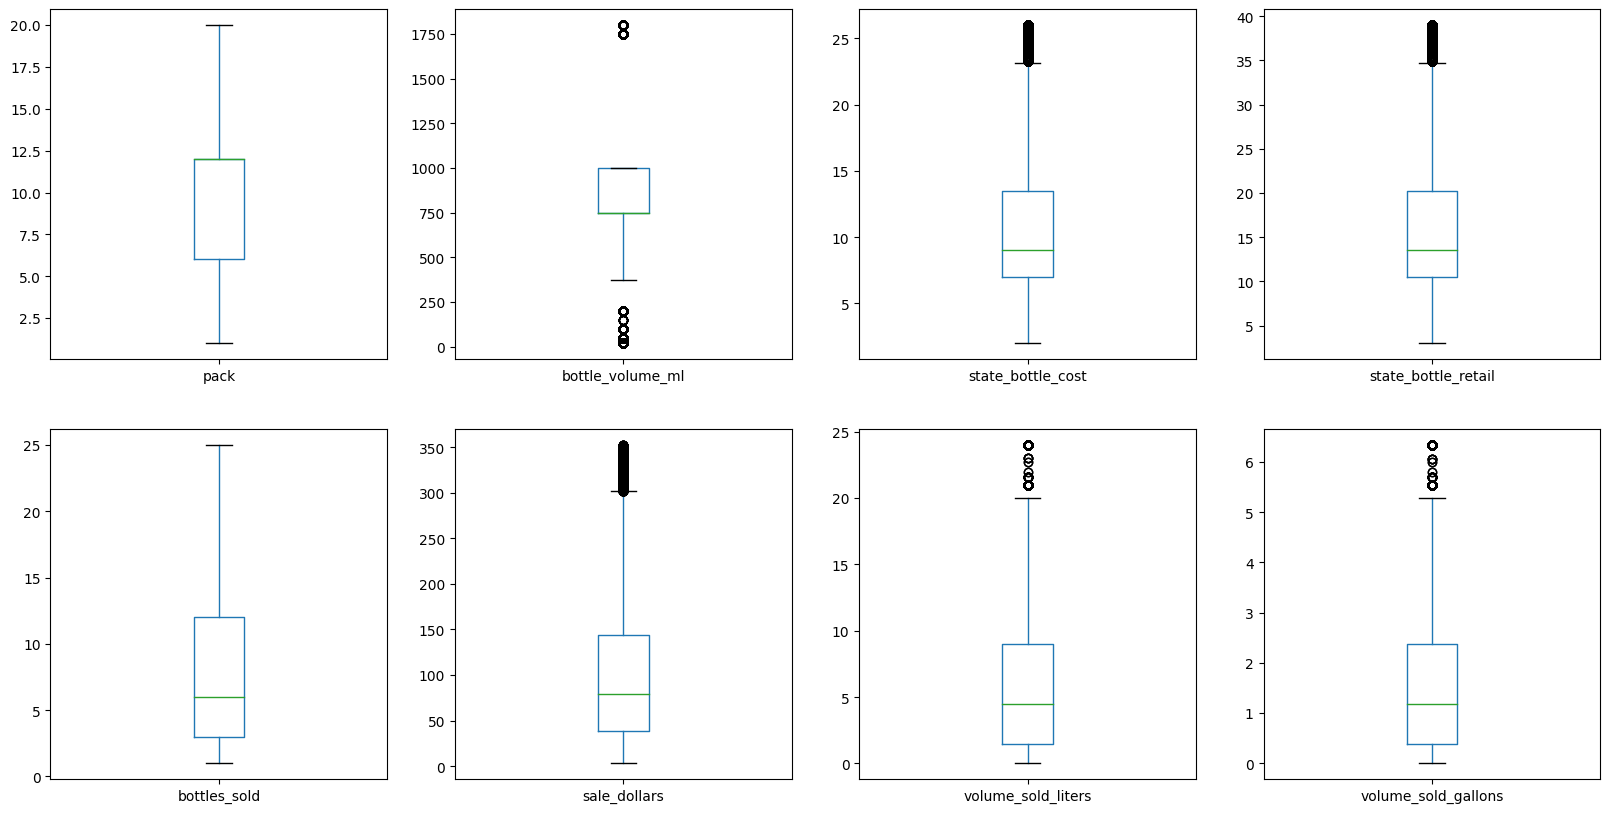

In [ ]:
# boxplot after removing outliers
feature = ['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']

#adjust chart position and chart size
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))

# for 0 (i) , Income (el)
for i,el in enumerate(feature):
    a = df_dc_out.boxplot(el, ax=axes.flatten()[i],grid=False)

#Show Chart
plt.show()

## EDA

In [ ]:
df_eda = df_dc_out.copy()

In [ ]:
df_eda['county']=df_eda['county'].str.upper()

In [ ]:
df_eda['city']=df_eda['city'].str.upper()

In [ ]:
df_eda.head()

In [ ]:
from google.colab import files

df_eda.to_csv('df_eda.csv', encoding = 'utf-8-sig', index = False)
files.download('df_eda.csv')

In [ ]:
#Descriptive analysis after treating the outlier
pd.set_option('display.float_format', lambda x: '%.3f' % x)

numeric = ['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']

desc_eda = df_eda[numeric].describe()
desc_eda.loc['kurtosis'] = df_eda[numeric].kurt() #show kurtosis statistic
desc_eda.loc['skewness'] = df_eda[numeric].skew() #show Skewness statistic
desc_eda.loc['variance'] = df_eda[numeric].var() #show variance statistic
desc_eda.round(2)

In [ ]:
df_eda.head()

Get Monthly Data Each variables

In [ ]:
trend_pack = df_eda[['date','pack']]    #Choose the variable wee need to make the chart
trend_pack['monthly'] = trend_pack['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_pack = trend_pack.sort_values('date')  #Sort the values by the issue month, ascending
trend_pack = trend_pack.groupby('monthly').sum() #sum the data and group it by the year_month
trend_pack = trend_pack.reset_index()

trend_botvol = df_eda[['date','bottle_volume_ml']]    #Choose the variable wee need to make the chart
trend_botvol['monthly'] = trend_botvol['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_botvol = trend_botvol.sort_values('date')  #Sort the values by the issue month, ascending
trend_botvol = trend_botvol.groupby('monthly').sum() #sum the data and group it by the year_month
trend_botvol = trend_botvol.reset_index()

trend_st_botcost = df_eda[['date','state_bottle_cost']]    #Choose the variable wee need to make the chart
trend_st_botcost['monthly'] = trend_st_botcost['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_st_botcost = trend_st_botcost.sort_values('date')  #Sort the values by the issue month, ascending
trend_st_botcost = trend_st_botcost.groupby('monthly').sum() #sum the data and group it by the year_month
trend_st_botcost = trend_st_botcost.reset_index()

trend_st_botretail = df_eda[['date','state_bottle_retail']]    #Choose the variable wee need to make the chart
trend_st_botretail['monthly'] = trend_st_botretail['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_st_botretail = trend_st_botretail.sort_values('date')  #Sort the values by the issue month, ascending
trend_st_botretail = trend_st_botretail.groupby('monthly').sum() #sum the data and group it by the year_month
trend_st_botretail = trend_st_botretail.reset_index()

trend_bot_sold = df_eda[['date','bottles_sold']]    #Choose the variable wee need to make the chart
trend_bot_sold['monthly'] = trend_bot_sold['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_bot_sold = trend_bot_sold.sort_values('date')  #Sort the values by the issue month, ascending
trend_bot_sold = trend_bot_sold.groupby('monthly').sum() #sum the data and group it by the year_month
trend_bot_sold = trend_bot_sold.reset_index()

trend_sale_dollars = df_eda[['date','sale_dollars']]    #Choose the variable wee need to make the chart
trend_sale_dollars['monthly'] = trend_sale_dollars['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_sale_dollars = trend_sale_dollars.sort_values('date')  #Sort the values by the issue month, ascending
trend_sale_dollars = trend_sale_dollars.groupby('monthly').sum() #sum the data and group it by the year_month
trend_sale_dollars = trend_sale_dollars.reset_index()

trend_vol_soldlit = df_eda[['date','volume_sold_liters']]    #Choose the variable wee need to make the chart
trend_vol_soldlit['monthly'] = trend_vol_soldlit['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_vol_soldlit = trend_vol_soldlit.sort_values('date')  #Sort the values by the issue month, ascending
trend_vol_soldlit = trend_vol_soldlit.groupby('monthly').sum() #sum the data and group it by the year_month
trend_vol_soldlit = trend_vol_soldlit.reset_index()

trend_vol_soldgal = df_eda[['date','volume_sold_gallons']]    #Choose the variable wee need to make the chart
trend_vol_soldgal['monthly'] = trend_vol_soldgal['date'].dt.strftime('%Y/%m')   #Change the issue month into year,month format to get monthly data
trend_vol_soldgal = trend_vol_soldgal.sort_values('date')  #Sort the values by the issue month, ascending
trend_vol_soldgal = trend_vol_soldgal.groupby('monthly').sum() #sum the data and group it by the year_month
trend_vol_soldgal = trend_vol_soldgal.reset_index()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_pack['monthly'], trend_pack['pack'])
plt.title('trend_pack', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_botvol['monthly'], trend_botvol['bottle_volume_ml'])
plt.title('bottle_volume_ml', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_st_botcost['monthly'], trend_st_botcost['state_bottle_cost'])
plt.title('state_bottle_cost', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_st_botretail['monthly'], trend_st_botretail['state_bottle_retail'])
plt.title('state_bottle_retail', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_bot_sold['monthly'], trend_bot_sold['bottles_sold'])
plt.title('bottles_sold', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_sale_dollars['monthly'], trend_sale_dollars['sale_dollars'])
plt.title('sale_dollars', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_vol_soldlit['monthly'], trend_vol_soldlit['volume_sold_liters'])
plt.title('volume_sold_liters', fontsize=20)

plt.show()

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_vol_soldgal['monthly'], trend_vol_soldgal['volume_sold_gallons'])
plt.title('volume_sold_gallons', fontsize=20)

plt.show()

Visualized According to Products

In [ ]:
#Make sales data to visualized

df_category = df_eda.groupby(['category_name'])['sale_dollars'].sum()
df_category = df_category.reset_index()
df_category = df_category.sort_values('sale_dollars', axis=0, ascending=False, inplace=False)
df_category.head()

In [ ]:
fig = plt.figure(figsize =(50, 15))

K = df_category.copy()

df_category.sort_values('sale_dollars', ascending= False, inplace= False)
x = K['category_name']
y = K['sale_dollars']
plt.xticks(rotation = 90, fontsize=20)
plt.yticks(rotation = 0, fontsize=20)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='bold', fontsize=20, rotation = 45)

plt.title("Most Sell")
plt.bar(x, y)   #Create the bar chart
plt.show()

In [ ]:
top_10_category = df_category.sort_values('sale_dollars', axis=0, ascending=False, inplace=False)
top_10_category = top_10_category.head(10)
top_10_category

In [ ]:
fig = plt.figure(figsize =(25, 10))

K = top_10_category.copy()

top_10_category.sort_values('sale_dollars', ascending= False, inplace= False)
x = K['category_name']
y = K['sale_dollars']
plt.xticks(rotation = 45, fontsize=15)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='bold', fontsize=15, rotation = 0)

plt.title("Top 10 Sales (In Dollars)")
plt.bar(x, y)   #Create the bar chart
plt.show()

Visualized According to Region

In [ ]:
#Make sales data to visualized

df_region = df_eda.groupby(['county'])['sale_dollars'].sum()
df_region = df_region.reset_index()
df_region = df_region.sort_values('sale_dollars', axis=0, ascending=False, inplace=False)
df_region.head()

In [ ]:
fig = plt.figure(figsize =(50, 15))

K = df_region.copy()

df_region.sort_values('sale_dollars', ascending= False, inplace= True)
x = K['county']
y = K['sale_dollars']
plt.xticks(rotation = 90, fontsize=15)
plt.yticks(rotation = 0, fontsize=20)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='normal', fontsize=15, rotation = 90)

plt.title("Consumers_County", fontsize = 25)
plt.bar(x, y)   #Create the bar chart
plt.show()

In [ ]:
top_10_region = df_region.sort_values('sale_dollars', axis=0, ascending=False, inplace=False)
top_10_region = top_10_region.head(10)
top_10_region

In [ ]:
fig = plt.figure(figsize =(25, 10))

K = top_10_region.copy()

top_10_region.sort_values('sale_dollars', ascending= False, inplace= False)
x = K['county']
y = K['sale_dollars']
plt.xticks(rotation = 45, fontsize=15)
plt.yticks(rotation = 0, fontsize=15)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='bold', fontsize=15, rotation = 0)

plt.title("Consumers Top 10 County (In Dollars)", fontsize=25)
plt.bar(x, y)   #Create the bar chart
plt.show()

In [ ]:
df_eda['Date Year'] = df_eda['date'].dt.year
df_eda['Date Month'] = df_eda['date'].dt.month
df_eda.head()

In [ ]:
df_fc_bp = pd.pivot_table(df_eda, values='bottles_sold', index=['county'],columns=['Date Month'], aggfunc=np.sum)
df_fc_bp

In [ ]:
df_fc_kp = pd.pivot_table(df_eda, values='sale_dollars', index=['county'],columns=['category_name'], aggfunc=np.sum)
df_fc_kp

In [ ]:
#from google.colab import files

#df_fc_bp.to_csv('df.csv', encoding = 'utf-8-sig', index = False)
#files.download('df.csv')

#F) ANSWER BUSINESS PROBLEM

## How was the trend of the number of bottles sold between January 2021 to January 2022 ?

In [ ]:
plt.figure(figsize =(20,6))

plt.xticks(rotation = 90)
plt.plot(trend_bot_sold['monthly'], trend_bot_sold['bottles_sold'])
plt.title('bottles_sold', fontsize=20)

plt.show()

## How much revenue does Iowa make from the business each month? Which product drives the most sales ?


## Are there any variations among regions in terms of the most popular product ?



In [ ]:
df_fc_kp = pd.pivot_table(df_eda, values='sale_dollars', index=['county'],columns=['category_name'], aggfunc=np.sum)
df_fc_kp

In [ ]:
fig = plt.figure(figsize =(50, 15))

K = df_region.copy()

df_region.sort_values('sale_dollars', ascending= False, inplace= True)
x = K['county']
y = K['sale_dollars']
plt.xticks(rotation = 90, fontsize=15)
plt.yticks(rotation = 0, fontsize=20)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='normal', fontsize=15, rotation = 90)

plt.title("Consumers_County", fontsize = 25)
plt.bar(x, y)   #Create the bar chart
plt.show()

In [ ]:
fig = plt.figure(figsize =(25, 10))

K = top_10_region.copy()

top_10_region.sort_values('sale_dollars', ascending= False, inplace= False)
x = K['county']
y = K['sale_dollars']
plt.xticks(rotation = 45, fontsize=15)
plt.yticks(rotation = 0, fontsize=15)
#Add the data labels
for i, v in enumerate(y):
    vmil = round(v)
    plt.text(i, v, str(vmil), fontweight='bold', fontsize=15, rotation = 0)

plt.title("Consumers Top 10 County (In Dollars)", fontsize=25)
plt.bar(x, y)   #Create the bar chart
plt.show()

## How many bottles will Iowa sell in the next three months ?

### Tes

In [ ]:
df_fc=df_eda.copy()

In [ ]:
numerical_column = ['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail',
                    'bottles_sold','sale_dollars','volume_sold_liters','volume_sold_gallons']

fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
for nomor, kolom in enumerate(numerical_column):
  df_fc.boxplot(kolom, ax=axes.flatten()[nomor],grid=False)
plt.show()

In [ ]:
df_fc['date'] = pd.to_datetime(df_fc['date'])
df_fc['date']

In [ ]:
fig = plt.figure(figsize=(25,10)) #ukuran canvas

ax = fig.add_subplot(1, 1, 1)
ax.set_title('bottles_sold')

sns.lineplot(data=df_fc,x='date',y='bottles_sold',ax=ax, color='blue')

plt.show()

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['pack'], lags = 30, title='autocol pack')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['bottle_volume_ml'], lags = 30, title='autocol bottle_volume_ml')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['state_bottle_cost'], lags = 30, title = 'autocol state_bottle_cost')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['state_bottle_retail'], lags = 30, title = 'autocol state_bottle_retail')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['bottles_sold'], lags = 30, title='autocol bottles_sold')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['sale_dollars'], lags = 30, title='autocol sale_dollars')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['volume_sold_liters'], lags = 30, title = 'autocol volume_sold_liters')
plt.show()

import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df_fc['volume_sold_gallons'], lags = 30, title = 'autocol volume_sold_gallons')
plt.show()

In [ ]:
# Order df_fc
df_fc2 = df_fc.sort_values(by = ['date']).copy()

# Set Date as index
df_fc2 = df_fc2.set_index(['date'])
df_fc2.tail()

In [ ]:
# Define predictor and
X = df_fc2[['pack','bottle_volume_ml','state_bottle_cost','state_bottle_retail',
            'sale_dollars','volume_sold_liters','volume_sold_gallons']]
y = df_fc2[['bottles_sold']]

# To test the accuracy of our forecast, let's only train the model until June 2012 and see forecast from it forward
X_train = X[X.index < '2022-01-31']
X_test = X[X.index >= '2022-01-31']

y_train = y[y.index < '2022-01-31']
y_test = y[y.index >= '2022-01-31']

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
from sklearn.linear_model import LinearRegression # model lin. reg

model = LinearRegression()
model.fit(X_train,y_train)

In [ ]:
model.score(X_train,y_train)

In [ ]:
# Create prediction for whole sample
df_prediction = y.copy()
df_prediction['predicted'] = model.predict(X)
df_prediction

In [ ]:
fig = df_prediction.plot(kind = 'line', figsize = (15, 8))
fig.axvline(x = '2022-04-30', color = 'black', dashes = (3, 2))
fig

## Tes 2

In [ ]:
bottles_sold_per_day = df_fc.groupby(['date'])['bottles_sold'].sum()
bottles_sold_per_day.plot(figsize=(16,6))

In [ ]:
dates = pd.date_range(start = '2022-02-01', end = '2022-04-30')
size = dates.size
val = [0]*size
bottles_sold_feb_to_april = pd.Series(val, index = dates)
bottles_sold_feb_to_april

In [ ]:
bottle_sold_jan2021_to_april2022 = bottles_sold_per_day.append(bottles_sold_feb_to_april)

In [ ]:
size_for_train = (bottle_sold_jan2021_to_april2022.size)-size #excluding the prediction dates
size_for_train
index = (bottle_sold_jan2021_to_april2022.size) - size_for_train #first index of prediction date

In [ ]:
# Training dataset
train = bottle_sold_jan2021_to_april2022.iloc[:size_for_train] #contains all dates from jan2021 - jan2022
# Test dataset
test = bottle_sold_jan2021_to_april2022.iloc[size_for_train:] #contains all dates from feb2022 - april2022

In [ ]:
model_SARIMA=SARIMAX(train,order=(3,0,5),seasonal_order=(1,0,1,12))

In [ ]:
#fitting the sarimax model
model_SARIMA_fit=model_SARIMA.fit()

In [ ]:
model_SARIMA_fit.summary()

In [ ]:
#Generating predictions using the SARIMAX model
pred_Sarima=model_SARIMA_fit.predict(1, index)

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(train.index, train.values, label='Actual')
sns.lineplot(test.index, pred_Sarima , label='Predicted')
#plt.ylim(0,180000)
plt.ylabel("# of bottle sold")
plt.xlabel("date")
plt.title("Actual and Predicted values of # of bottles sold.")